<a href="https://colab.research.google.com/github/MangutTatarin/DataScience/blob/main/23102023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*Мутулов Мангут Михайлович,* Практический кейс


## *Описание задачи*

В качестве исходных данных были взяты результаты экспериментальных  исследований, проводимых в целях улучшения технологического процесса электронно-лучевой сварки изделия, сборка которого состоит из элементов, состоящих из разнородного материала.



Установка электронно-лучевой сварки, на которой проводились исследования, предназначена для сварки электронным лучом в глубоком вакууме деталей сборочных единиц из нержавеющих сталей, титановых, алюминиевых и специальных сплавов.


Существующая установка электронно-лучевой сварки обеспечивает повторяемость режимов в рамках возможностей реализованной системы управления. Работы по сварке выполнялись на образцах-имитаторах, соответствующих технологическому изделию.


Для уменьшения вложения энергии при сварке:

1.	Снижалась величина сварочного тока (IW);
2.	Увеличивался ток фокусировки электронного пучка (IF);
3.	Увеличивалась скорость сварки (VW);
4.	Менялось расстояние от поверхности образцов до электронно-оптической системы (FP).

*По совокупности параметров технологических режимов обеспечивались минимально возможные размеры сварных швов: глубина шва (Depth) и ширина шва (Width).*

В процессе выполнения работ была произведена электронно-лучевая сварка 18-ти единиц образцов. Результаты металлографического контроля по размерам сварного шва для каждого образца проводились в 4-х поперечных сечениях сварного шва. Ускоряющее напряжение было постоянным в диапазоне 19,8 – 20 кВ. Набор полученных данных собраны в составе режимов сварки, размеров сварочных швов в поперечных сечениях всех образцов.

## **Задача**:
Решить задачу регрессии (одним или несколькими методами) для предсказания глубины и ширины сварного соединения, выполнив необходимые этапы (разведочный анализ, предобработка)

## Импорт необходимых библиотек

In [1]:
!pip install phik --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 679.5/679.5 kB 7.7 MB/s eta 0:00:00


In [2]:
import warnings
warnings.filterwarnings("ignore")# чтобы не было видно ошибок
import pandas as pd # загружаем и обрабатываем данные, делаем предварительный анализ
import numpy as np # обрабатываем с массивы и тензоры
import matplotlib.pyplot as plt # рисуем графики, делаем визуализацию
import seaborn as sns # рисуем еще другие графики, делаем еще лучше визуализацию
import tensorflow as tf # библиотека для машинного обучения

from matplotlib import rcParams # для изменений параметров отображаемых графиков по умолчанию
import phik # Библиотека корреляционного анализатора
from phik import resources, report # импотрируем из библиотеки корреляционного анализатора
from phik.report import plot_correlation_matrix # для графиков библиотеки корреляционного анализатора
import sklearn # библиотека программного обеспечения для машинного обучения
from sklearn import metrics # посмотрим функции оценки ошибки прогноза для конкретных целей
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score # посмотрим среднеквадратичную ошибка, средняя абсолютную ошибку и коэффициент детерминации
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, KFold # делим выборку на тестовую и тренировочную, используем кросс-валидацию

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV # инструмент для автоматического подбирания параметров для моделей машинного обучения и рандомизированный поиск по параметрам
from sklearn.svm import SVR # метод опорных векторов
from tensorflow import keras # библиотека, обеспечивающая взаимодействие с искусственными нейронными сетями

## **Разведочный анализ**
Разведочный анализ данных (Exploratory Data Analysis) – предварительное исследование Датасета (Dataset) с целью определения его основных характеристик, взаимосвязей между признаками, а также сужения набора методов, используемых для создания Модели (Model) Машинного обучения (Machine Learning)

### *1) Первичный обзор.* Посмотрим на наш датасет, чтобы получить общее представление о его содержимом

In [3]:
from google.colab import drive
drive.mount('/content/drive') #монтируем файлы из моего google диска, где хранится датасет
df = pd.read_csv('/content/drive/MyDrive/bnju/ebw_data.csv') # загружаем датасет
df.head(3) # выводим первые три строки

Mounted at /content/drive


,IW,IF,VW,FP,Depth,Width
0,47,139,4.5,80,1.60,2.54
1,47,139,4.5,80,1.62,2.50
2,47,139,4.5,80,1.68,2.60


### *2) Обработка пропущенных значений.*
Работа с отсутствующими значениями – одна из самых сложных, но и самых распространенных проблем очистки. Большинство моделей не предполагают пропусков.

In [4]:
# Проверим набор данных на пропуски, хотя и так было ясно. датасет небольшой и я его тупо распечатал (на бумаге) :)
df.isna().sum()
#Пропусков нет

IW       0
IF       0
VW       0
FP       0
Depth    0
Width    0
dtype: int64

In [5]:
df.columns # Выведим названия столбцов, чтобы потом было удобно копировать их названия :)

Index(['IW', 'IF', 'VW', 'FP', 'Depth', 'Width'], dtype='object')

## Разработка и обучение модели машинного обучения

In [6]:
# Решил вернуться к исходному датасету. Определим входные и выходные параметры для модели машинного обучения

x = df[['IW', 'IF', 'VW', 'FP']].values # вход
y = df[['Depth', 'Width']].values # выход

x.shape, y.shape # проверяем размерность параметров.

((72, 4), (72, 2))

In [7]:
# Разбиваем выборки на обучающую и тестовую
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 14)

In [8]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape #Проверим размерность

((50, 4), (22, 4), (50, 2), (22, 2))

In [9]:
# Датасет для сбора полученных метрик
m_s = pd.DataFrame()

### Метод опорных векторов Support Vector Regression

In [10]:
from sklearn.svm import SVR
svr = SVR()
svr_params = {'C': [0.1, 1, 10, 100, 500, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']}

In [11]:
# Попробуем сделать предсказания по каждому параметру в отдельности, сначала Depth
y_1 = y[:, 0]
x_train_1, x_test_1, y_train_1, y_test_1 = train_test_split(x, y_1, test_size = 0.3, random_state = 14)
y_train_1

array([1.32, 1.28, 1.08, 1.08, 1.28, 0.96, 1.12, 1.24, 1.28, 1.36, 1.2 ,
       0.8 , 1.16, 1.4 , 1.2 , 1.64, 1.62, 1.24, 0.94, 1.2 , 1.36, 1.2 ,
       1.  , 1.36, 1.2 , 1.2 , 1.  , 1.58, 0.8 , 1.12, 1.22, 1.08, 0.84,
       1.72, 1.12, 1.28, 1.6 , 1.2 , 1.36, 1.02, 1.76, 1.08, 0.84, 0.96,
       0.92, 1.24, 1.16, 1.36, 1.2 , 0.98])

In [12]:
# обучаем модель с параметрами по умолчанию
svr.fit(x_train_1, y_train_1)

SVR()

In [13]:
# запускаем предсказания для модели на основе тестового набора данных x_test
y_svr = svr.predict(x_test_1)
# выведем первые пять значений с помощью диапазона индексов
print(y_svr[:5])
print(y_test_1[:5])

[1.21688694 1.22505994 1.2032221  1.25748639 1.25265571]
[1.2  1.08 1.08 1.64 1.32]


In [14]:
print("Среднеквадратичная ошибка, полученная с параметрами по умолчанию:", mean_squared_error(y_test_1, y_svr))
print("Средняя абсолютная ошибка, полученная с параметрами по умолчанию:", mean_absolute_error(y_test_1, y_svr))
print("Коэффициент детерминации, полученный с параметрами по умолчанию:", r2_score(y_test_1, y_svr))

Среднеквадратичная ошибка, полученная с параметрами по умолчанию: 0.019916184699451892
Средняя абсолютная ошибка, полученная с параметрами по умолчанию: 0.09220650054504903
Коэффициент детерминации, полученный с параметрами по умолчанию: 0.5767128594404414


In [15]:
# метрики, полученные моделью с параметрами по умолчанию заносим в наш датасет с параметрами ошибок
svr_r = pd.DataFrame({
   'Model': 'SVR_D_default',
   'MSE': metrics.mean_squared_error(y_test_1, y_svr),
   'MAE': metrics.mean_absolute_error(y_test_1, y_svr),
    'R^2': metrics.r2_score(y_test_1, y_svr)
   }, index = ['SVR_D'])

In [16]:
m_s = pd.concat([m_s, svr_r])
m_s_s = m_s.sort_values(by = ['MAE', 'R^2'])
m_s_s

,Model,MSE,MAE,R^2
SVR_D,SVR_D_default,0.019916,0.092207,0.576713


In [ ]:
# поиск лучших гиперпараметров модели с помощью поиска по сетке с перекрестной проверкой, количество блоков равно 10
GSCV_svr_best = GridSearchCV(svr, svr_params, n_jobs =- 1, cv = 10)
GSCV_svr_best.fit(x_train_1, y_train_1)
GSCV_svr_best.best_params_

In [18]:
svr_best = GSCV_svr_best.best_estimator_

In [19]:
svr_best_r = pd.DataFrame({
   'Model': 'SVR_D_best',
   'MSE': metrics.mean_squared_error(y_test_1, svr_best.predict(x_test_1)),
   'MAE': metrics.mean_absolute_error(y_test_1, svr_best.predict(x_test_1)),
   'R^2': metrics.r2_score(y_test_1, svr_best.predict(x_test_1))
   }, index=['SVR_D'])

In [20]:
print("Среднеквадратичная ошибка, полученная с лучшими гиперпараметрами:", mean_squared_error(y_test_1, svr_best.predict(x_test_1)))
print("Средняя абсолютная ошибка, полученная с лучшими гиперпараметрами:", mean_absolute_error(y_test_1, svr_best.predict(x_test_1)))
print("Коэффициент детерминации, полученный с лучшими гиперпараметрами:", r2_score(y_test_1, svr_best.predict(x_test_1)))

Среднеквадратичная ошибка, полученная с лучшими гиперпараметрами: 0.006999633888943892
Средняя абсолютная ошибка, полученная с лучшими гиперпараметрами: 0.07135155545519599
Коэффициент детерминации, полученный с лучшими гиперпараметрами: 0.8512338051425892


In [21]:
m_s = pd.concat([m_s, svr_best_r])
m_s_s = m_s.sort_values(by = ['MAE', 'R^2'])
m_s_s

,Model,MSE,MAE,R^2
SVR_D,SVR_D_best,0.007000,0.071352,0.851234
SVR_D,SVR_D_default,0.019916,0.092207,0.576713


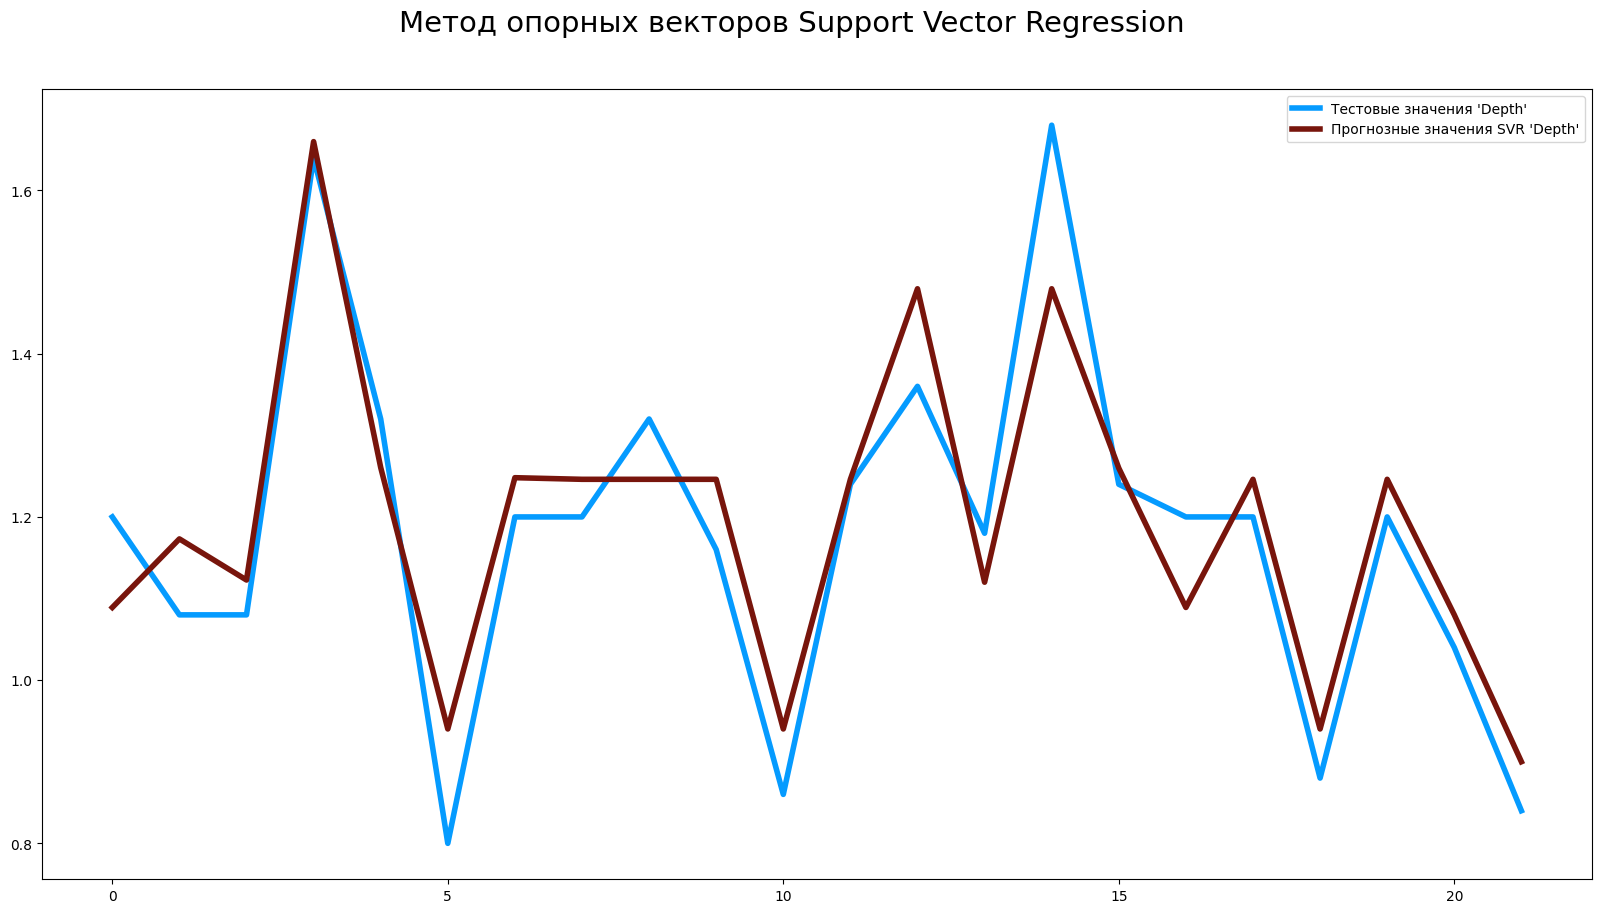

In [22]:
plt.figure(figsize = (20, 10))
plt.suptitle("Метод опорных векторов Support Vector Regression", size = 21)
plt.subplots_adjust(top = 0.90)
plt.plot(range(len(y_test_1)), y_test_1, label = "Тестовые значения 'Depth'", color = '#059bff', linewidth = 4)
plt.plot(range(len(svr_best.predict(x_test_1))), svr_best.predict(x_test_1), color = '#78150c', label = "Прогнозные значения SVR 'Depth'", linewidth = 4)
plt.legend(loc = 'best', fontsize = 10)

In [23]:
#Повторим тоже самое для параметра "Width"
svr_1 = SVR()
svr_1_params = {'C': [0.1, 1, 10, 100, 500, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']}

In [24]:
#Попробуем сделать предсказания по каждому параметру в отдельности, теперь Width
y_2 = y[:, 1]
x_train_2, x_test_2, y_train_2, y_test_2 = train_test_split(x, y_2, test_size = 0.3, random_state = 14)
y_train_2

array([1.84, 1.76, 1.68, 1.8 , 1.8 , 2.  , 1.8 , 1.78, 1.8 , 1.76, 1.96,
       2.24, 1.8 , 2.48, 1.76, 2.56, 2.5 , 1.72, 1.94, 1.96, 2.48, 1.88,
       1.84, 1.76, 1.72, 1.72, 1.86, 2.52, 2.28, 1.76, 1.82, 1.82, 2.24,
       2.48, 1.71, 1.76, 2.54, 1.76, 1.76, 1.84, 2.48, 1.82, 2.16, 1.94,
       1.86, 1.8 , 1.96, 2.52, 1.8 , 1.84])

In [25]:
# обучаем модель с параметрами по умолчанию
svr_1.fit(x_train_2, y_train_2)

SVR()

In [26]:
# запускаем предсказания для модели на основе тестового набора данных x_test
y_svr_1 = svr_1.predict(x_test_2)
# выведем первые пять значений с помощью диапазона индексов
print(y_svr_1[:5])
print(y_test_2[:5])

[1.9152613  1.76963801 1.89408978 1.97808008 1.82059819]
[1.78 1.82 1.72 2.52 1.76]


In [27]:
print("Среднеквадратичная ошибка, полученная с параметрами по умолчанию:", mean_squared_error(y_test_2, y_svr_1))
print("Средняя абсолютная ошибка, полученная с параметрами по умолчанию:", mean_absolute_error(y_test_2, y_svr_1))
print("Коэффициент детерминации, полученный с параметрами по умолчанию:", r2_score(y_test_2,y_svr_1))

Среднеквадратичная ошибка, полученная с параметрами по умолчанию: 0.049900052360522335
Средняя абсолютная ошибка, полученная с параметрами по умолчанию: 0.14757187600117946
Коэффициент детерминации, полученный с параметрами по умолчанию: 0.29142534670900777


In [28]:
# метрики, полученные моделью с параметрами по умолчанию заносим в наш датасет с параметрами ошибок
svr_r_1 = pd.DataFrame({
   'Model': 'SVR_W_default	',
   'MSE': metrics.mean_squared_error(y_test_2, y_svr_1),
   'MAE': metrics.mean_absolute_error(y_test_2, y_svr_1),
    'R^2': metrics.r2_score(y_test_2, y_svr_1)
   }, index = ['SVR_W'])

In [29]:
m_s = pd.concat([m_s, svr_r_1])
m_s_s = m_s.sort_values(by = ['MAE', 'R^2'])
m_s_s

,Model,MSE,MAE,R^2
SVR_D,SVR_D_best,0.007000,0.071352,0.851234
SVR_D,SVR_D_default,0.019916,0.092207,0.576713
SVR_W,SVR_W_default\t,0.049900,0.147572,0.291425


In [30]:
# поиск лучших гиперпараметров модели с помощью поиска по сетке с перекрестной проверкой, количество блоков равно 10
GSCV_svr_1_best = GridSearchCV(svr_1, svr_1_params, n_jobs =- 1, cv = 10)
GSCV_svr_1_best.fit(x_train_2, y_train_2)
GSCV_svr_1_best.best_params_

{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}

In [31]:
svr_1_best = GSCV_svr_1_best.best_estimator_

In [32]:
svr_1_best_r = pd.DataFrame({
   'Model': 'SVR_Width_best',
   'MSE': metrics.mean_squared_error(y_test_2, svr_1_best.predict(x_test_2)),
   'MAE': metrics.mean_absolute_error(y_test_2, svr_best.predict(x_test_2)),
   'R^2': metrics.r2_score(y_test_2, svr_1_best.predict(x_test_2))
   }, index=['SVR_W'])

In [33]:
print("Среднеквадратичная ошибка, полученная с лучшими гиперпараметрами:", mean_squared_error(y_test_2, svr_1_best.predict(x_test_2)))
print("Средняя абсолютная ошибка, полученная с лучшими гиперпараметрами:", mean_absolute_error(y_test_2, svr_1_best.predict(x_test_2)))
print("Коэффициент детерминации, полученный с лучшими гиперпараметрами:", r2_score(y_test_2, svr_1_best.predict(x_test_2)))

Среднеквадратичная ошибка, полученная с лучшими гиперпараметрами: 0.007000946439664837
Средняя абсолютная ошибка, полученная с лучшими гиперпараметрами: 0.07010227285709206
Коэффициент детерминации, полученный с лучшими гиперпараметрами: 0.9005874150120352


In [34]:
m_s = pd.concat([m_s, svr_1_best_r])
m_s_s = m_s.sort_values(by = ['MAE', 'R^2'])
m_s_s

,Model,MSE,MAE,R^2
SVR_D,SVR_D_best,0.007000,0.071352,0.851234
SVR_D,SVR_D_default,0.019916,0.092207,0.576713
SVR_W,SVR_W_default\t,0.049900,0.147572,0.291425
SVR_W,SVR_Width_best,0.007001,0.770078,0.900587


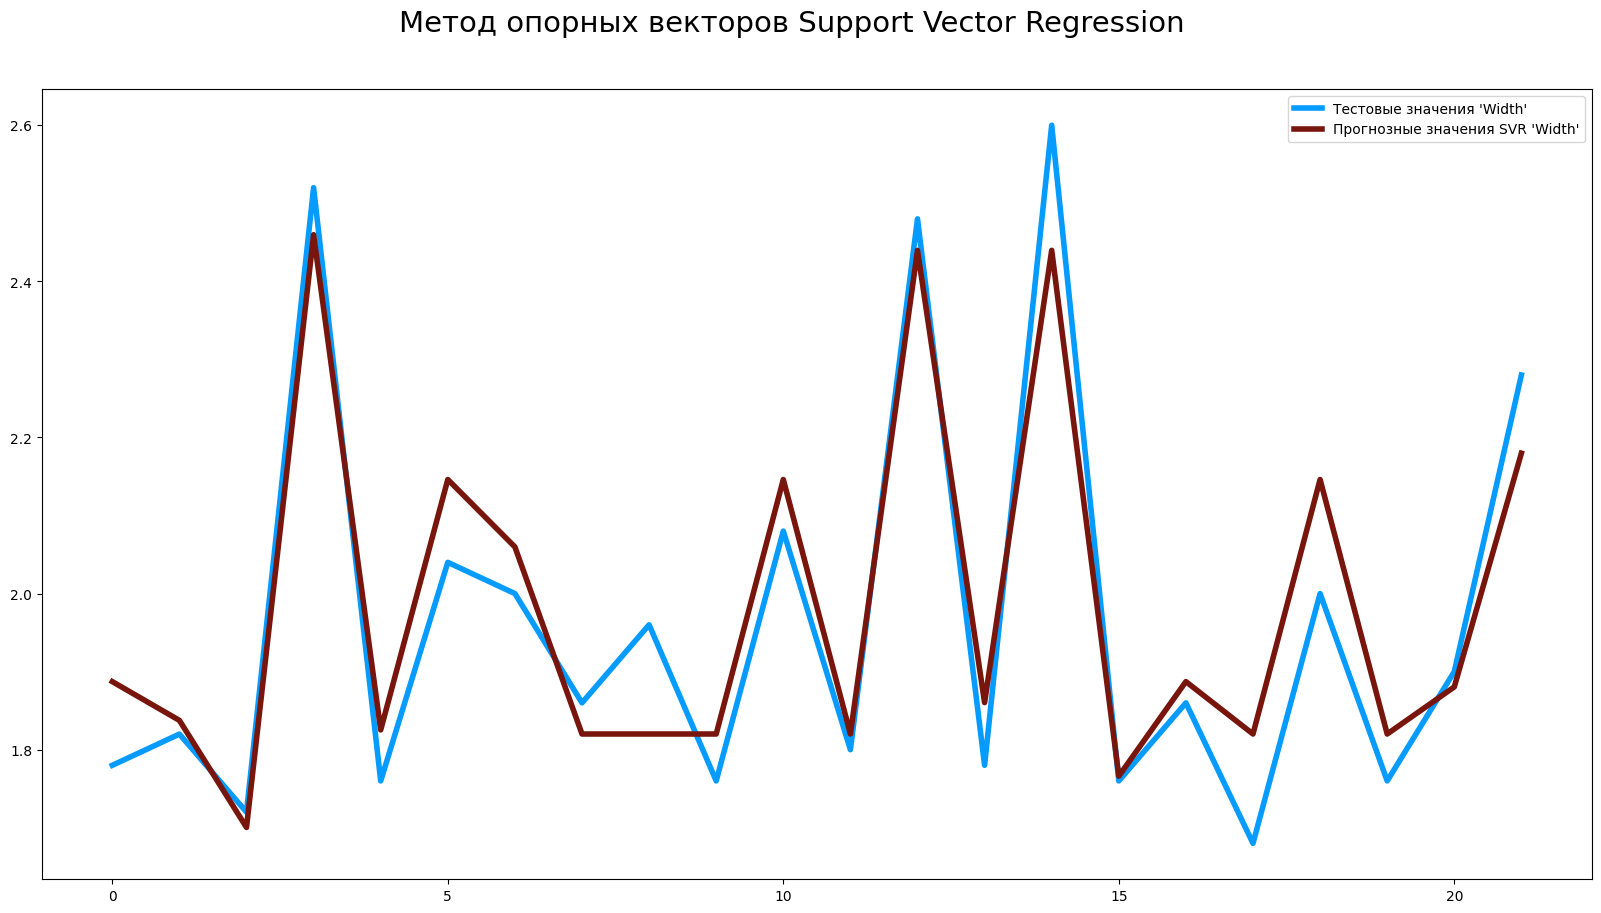

In [35]:
plt.figure(figsize = (20, 10))
plt.suptitle("Метод опорных векторов Support Vector Regression", size = 21)
plt.subplots_adjust(top = 0.90)
plt.plot(range(len(y_test_2)), y_test_2, label = "Тестовые значения 'Width'", color = '#059bff', linewidth = 4)
plt.plot(range(len(svr_1_best.predict(x_test_2))), svr_1_best.predict(x_test_2), color = '#78150c', label = "Прогнозные значения SVR 'Width'", linewidth = 4)
plt.legend(loc = 'best', fontsize = 10)

### Нейронные сети

In [36]:
n_r = tf.keras.layers.Normalization(axis =- 1)

In [37]:
n_r.adapt(np.array(x))

In [38]:
# Функция, собирающая нейросеть заданной архитектуры
def c_m():
    return tf.keras.Sequential([
      keras.layers.Input(shape = (4,), name = 'in'),
      keras.layers.Dense(units = 64, activation = 'relu', name = 'dense_1'),
      keras.layers.Dense(units = 32, activation = 'relu', name = 'dense_2'),
      keras.layers.Dense(units = 12, activation = 'relu', name = 'dense_3'),
      keras.layers.Dense(units = 2, name = 'out')
    ])

In [39]:
# Функция, компилирующая нейросеть с заданными параметрами
def com_m(model):
    model.compile(
             optimizer = keras.optimizers.Adam(),
             loss = keras.losses.MeanAbsolutePercentageError(),
             metrics = [tf.keras.metrics.RootMeanSquaredError()]
             )
    return model

In [40]:
# cборка
model_1 = c_m()

In [41]:
# компиляция
model_1 = com_m(model_1)

In [42]:
# сводная информация по архитектуре сети
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 64)                320       
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 12)                396       
                                                                 
 out (Dense)                 (None, 2)                 26        
                                                                 
Total params: 2822 (11.02 KB)
Trainable params: 2822 (11.02 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


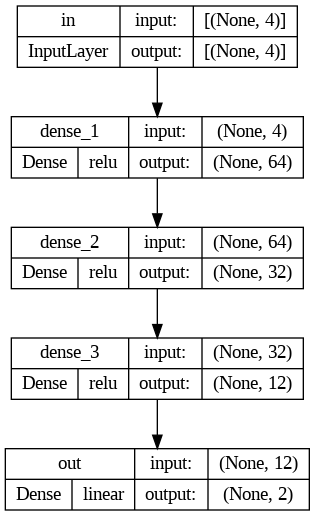

In [43]:
# архитектура нейросети
keras.utils.plot_model(model_1, show_shapes = True, show_layer_names = True, show_layer_activations = True)

In [44]:
%%time
#обучение нейросети
history_1 = model_1.fit(
  x,
  y,
  epochs = 100,
  validation_data = (x_test,y_test),
  verbose = 1
)

Epoch 1/100
3/3 [==============================] - 1s 106ms/step - loss: 247.0973 - root_mean_squared_error: 3.8334 - val_loss: 78.7702 - val_root_mean_squared_error: 2.0478
Epoch 2/100
3/3 [==============================] - 0s 17ms/step - loss: 86.5104 - root_mean_squared_error: 1.8708 - val_loss: 75.5150 - val_root_mean_squared_error: 1.4005
Epoch 3/100
3/3 [==============================] - 0s 17ms/step - loss: 67.3374 - root_mean_squared_error: 1.2535 - val_loss: 77.2439 - val_root_mean_squared_error: 1.4732
Epoch 4/100
3/3 [==============================] - 0s 18ms/step - loss: 67.9345 - root_mean_squared_error: 1.3434 - val_loss: 54.8020 - val_root_mean_squared_error: 0.8539
Epoch 5/100
3/3 [==============================] - 0s 19ms/step - loss: 52.8618 - root_mean_squared_error: 0.8383 - val_loss: 51.9194 - val_root_mean_squared_error: 0.8748
Epoch 6/100
3/3 [==============================] - 0s 26ms/step - loss: 41.7633 - root_mean_squared_error: 0.7288 - val_loss: 37.1285 - va

In [45]:
y_pred = model_1.predict(x_test)

1/1 [==============================] - 0s 93ms/step


In [46]:
y_pred

array([[1.1172771 , 1.7222127 ],
       [1.0455292 , 1.4870719 ],
       [1.1371317 , 1.7101141 ],
       [1.3473264 , 2.0792801 ],
       [1.1296166 , 1.5983616 ],
       [0.68488955, 2.1117978 ],
       [1.0887562 , 1.7472261 ],
       [1.1397814 , 1.5625732 ],
       [1.1397814 , 1.5625732 ],
       [1.1397814 , 1.5625732 ],
       [0.68488955, 2.1117978 ],
       [1.1397814 , 1.5625732 ],
       [1.4932863 , 2.3586736 ],
       [1.1615064 , 1.8554118 ],
       [1.4932863 , 2.3586736 ],
       [1.1622894 , 1.6646849 ],
       [1.1172771 , 1.7222127 ],
       [1.1397814 , 1.5625732 ],
       [0.68488955, 2.1117978 ],
       [1.1397814 , 1.5625732 ],
       [1.0595732 , 1.5903124 ],
       [0.8760102 , 2.148989  ]], dtype=float32)

In [47]:
y_test

array([[1.2 , 1.78],
       [1.08, 1.82],
       [1.08, 1.72],
       [1.64, 2.52],
       [1.32, 1.76],
       [0.8 , 2.04],
       [1.2 , 2.  ],
       [1.2 , 1.86],
       [1.32, 1.96],
       [1.16, 1.76],
       [0.86, 2.08],
       [1.24, 1.8 ],
       [1.36, 2.48],
       [1.18, 1.78],
       [1.68, 2.6 ],
       [1.24, 1.76],
       [1.2 , 1.86],
       [1.2 , 1.68],
       [0.88, 2.  ],
       [1.2 , 1.76],
       [1.04, 1.9 ],
       [0.84, 2.28]])

In [48]:
# точность нейросети на тестовых данных
model_1.evaluate(x_test, y_test)

1/1 [==============================] - 0s 38ms/step - loss: 9.0547 - root_mean_squared_error: 0.1771


[9.054688453674316, 0.1771240234375]

In [49]:
# предсказание
y_pred_keras1 = model_1.predict(x_test)

1/1 [==============================] - 0s 21ms/step


In [50]:
y_pred_keras1

array([[1.1172771 , 1.7222127 ],
       [1.0455292 , 1.4870719 ],
       [1.1371317 , 1.7101141 ],
       [1.3473264 , 2.0792801 ],
       [1.1296166 , 1.5983616 ],
       [0.68488955, 2.1117978 ],
       [1.0887562 , 1.7472261 ],
       [1.1397814 , 1.5625732 ],
       [1.1397814 , 1.5625732 ],
       [1.1397814 , 1.5625732 ],
       [0.68488955, 2.1117978 ],
       [1.1397814 , 1.5625732 ],
       [1.4932863 , 2.3586736 ],
       [1.1615064 , 1.8554118 ],
       [1.4932863 , 2.3586736 ],
       [1.1622894 , 1.6646849 ],
       [1.1172771 , 1.7222127 ],
       [1.1397814 , 1.5625732 ],
       [0.68488955, 2.1117978 ],
       [1.1397814 , 1.5625732 ],
       [1.0595732 , 1.5903124 ],
       [0.8760102 , 2.148989  ]], dtype=float32)

In [51]:
y_test

array([[1.2 , 1.78],
       [1.08, 1.82],
       [1.08, 1.72],
       [1.64, 2.52],
       [1.32, 1.76],
       [0.8 , 2.04],
       [1.2 , 2.  ],
       [1.2 , 1.86],
       [1.32, 1.96],
       [1.16, 1.76],
       [0.86, 2.08],
       [1.24, 1.8 ],
       [1.36, 2.48],
       [1.18, 1.78],
       [1.68, 2.6 ],
       [1.24, 1.76],
       [1.2 , 1.86],
       [1.2 , 1.68],
       [0.88, 2.  ],
       [1.2 , 1.76],
       [1.04, 1.9 ],
       [0.84, 2.28]])

### Сохранение моделей

In [61]:
model_1.save('Users')

In [53]:
import pickle # сохраняем объекты моделей в файлы

In [54]:
pickle.dump(model_1, open(r'C:\Users\Физика\PycharmProjects\pythonProject\model_1.pkl', 'wb'))

In [55]:
model_load_width = pickle.load(open(r'C:\Users\Физика\PycharmProjects\pythonProject\model_1.pkl', 'rb'))

In [56]:
model_load_width.predict([[45., 141., 10., 80.]])

1/1 [==============================] - 0s 84ms/step


array([[1.0595734, 1.5903143]], dtype=float32)